# Prediction


In this notebook all the Classification models work on a **<font color="red"> toxic dataset of 30K observations</font>**, drawn from the csv used in the previous notebook.    
For this reason, **it's extremely slow (almost 1 day to be run).**  

### Table of Contents - 2
[4. Prediction (15 pts)](#Prediction)  
[4.1 Classification (9 pts)](#Classification)  
[4.1.1. Dummy Baseline](#DummyBaseline)  
[4.1.2. Logistic Regression](#LogisticRegression)  
[4.1.2.1. Logistic Regression with `class_weight`](#LogisticRegression1)  
[4.1.2.2. Logistic Regression with L2 Regularization](#LogisticRegression2)  
[4.1.2.3. Logistic Regression with Feature selection](#LogisticRegression3)  
[4.1.2.3.1. ChiSquared](#chi2)  
[4.1.2.3.2. SVD Dimensionality Reduction](#dim)  
[4.1.2.4. Best LOGIT Model](#best_SVM)  
[4.1.3. Logistic Regression with 2-6 grams features](#logit26)  
[4.1.4. Model Selection](#further_model_selection)    
[4.1.5. Support Vector Machine](#svm)      
[4.1.5.1. Linear SVM with L2 Regularization](#best_params_LSVM)      
[4.1.5.2.  Linear SVM with Feature selection](#feature_selection_LSVM)    
[4.1.5.2.1. ChiSquared](#chi2_LSVM)    
[4.1.5.2.2. Dimensionality Reduction](#SVD_LSVM)    
[4.1.5.3. RBF SVM with Penalty and Gamma](#best_params_RSVM)    
[4.1.5.4. RBF SVM with Feature selection](#feature_selection_RSVM)  
[4.1.5.4.1. ChiSquared](#chi2_RSVM)  
[4.1.5.4.2. SVD Dimensionality Reduction](#SVD_RSVM)  
[4.1.5.5. Best SVM Model](#best_SVM)  
[4.1.6. Multilayer Perceptron](#mlp)    
[4.1.6.1. Best parameters](#best_params_mlp)  
[4.1.7. MLP with multiple labels as input](#mlp2)    
[4.1.8. Convolutional NN](#cnn)    
[4.1.9. Best Classifier](#recap)  
[4.1.10. Bootstrap sampling significance tests](#boot)  


In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2) 
import re
import json
import sys
import pickle
import random
import spacy
nlp = spacy.load("en_core_web_sm")
import ast

from collections import defaultdict, Counter
from datetime import datetime
from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier

from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from matplotlib import gridspec
import seaborn as sns
sns.set_style("dark")

from keras.models import Sequential, Model
from keras import layers
from keras.layers import Input, Embedding, Dropout, Dense, Activation, Conv1D, Flatten, InputLayer
from keras.preprocessing import text, sequence 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Bidirectional, LSTM
import os

Using TensorFlow backend.


In [2]:
b_dir =os.getcwd()

# 4. Prediction (15 pts)
<a id="Prediction"></a>

# 4.1 Classification (9 pts)
<a id="Classification"></a>
Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a **most-frequent-label** baseline (1 pt);
2. a **LogisticRegression** baseline with default parameters and **2-6 gram character TFIDF** features (1 pt);
3. the performance of **at least two** more predictive model architecture (2 pts each), including description/justification of the optmization steps taken (2 pts);
4. **two bootstrap sampling significance tests** of the performance difference between your best model and each of the two baselines (1 pts).

NB: Do make sure that the optimization steps are done on the development split and do *not* include the test split! Training on the test set will be graded 0!

****
**Dataset:** TOXIC COMMENTS "data_LABEL3.csv" &rarr; "30k_sample.csv"  
We used a sample of the entire dataset, with only 30 thousands observations. The reason behind this choice is that we wanted to rebalance the toxic and the non-toxic comments to obtain better predictions.  

Since our goal is to find the best performing classifier, before fitting each model, we did a feature selection.

*Disclaimer: the dataset contains text that may be considered profane, vulgar, or offensive.*

In [3]:
# Importing dataset
data = pd.read_csv(os.path.join(b_dir,"30k_sample.csv"))
#data.head(2)

In [4]:
# FUNCTION DEFINITION: SIGNIFICANCE TEST 
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas


def eval_input(model,train,y_train,inputt:list,CV=3):
    CV = 3
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for inp in inputt:
        X_train = vectorizer.fit_transform(train[inp])
        accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((inp, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    cv_df.groupby('model_name').accuracy.mean()
    cv_fin=cv_df.groupby('model_name')[["accuracy"]].mean().sort_values(by="accuracy",ascending=False)
    return cv_fin


# FUNCTION DEFINITION: PLOT SCORES TUNING 
def plot_scores(parameter_list,score_list, xlabel):
    line1, = plt.plot(parameter_list, score_list, 'b', label='Dev Score')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=1)})
    plt.ylabel('Score')
    plt.xlabel(xlabel)
    return plt.show()

In [5]:
'''CREATING TRAIN-DEV-TEST SETS:
The proportion really depends on the volume of our dataset. If the dataset is very large and we can guarantee 
that the different sets will have a similar class distribution, then we can also increase the training set
while reducing the dev and test sets. To avoid that algorithms memorize patterns, we shuffle the data.
'''
data = data[data['tokens_ex'].isna() == False]
np.random.seed(9)
data = data.sample(frac=1)

N = len(data)
train_size = int(N*0.6)
dev_size = int(N*0.2)
test_size = int(N*0.2)

train = data[:train_size]
dev = data[train_size: train_size+dev_size]
test = data[train_size+dev_size:]
print(len(train), len(dev), len(test))
print()
#train.head()

'''TRANSFORMING LABELS'''
target = 'negative'
labels2numbers = LabelEncoder()
y_train = labels2numbers.fit_transform(train[target])
y_dev = labels2numbers.transform(dev[target])
y_test = labels2numbers.transform(test[target])
print("Classification Outputs are: {}".format(labels2numbers.classes_))

print()
print("How many negative vs. not_negative comments (entire dataset) ?")
print(len(data[data['negative']==1]), len(data[data['negative']==0]))
print()

'''CLASSES DISTRIBUTION IN THE TEST-DEV-TRAIN DATASETS'''
print("Classes distribution in TRAIN: {}".format({labels2numbers.classes_[k]: v/len(y_train) for k, v in Counter(y_train).items()}))
print("Classes distribution in DEV: {}".format({labels2numbers.classes_[k]: v/len(y_dev) for k, v in Counter(y_dev).items()}))
print("Classes distribution in TEST: {}".format({labels2numbers.classes_[k]: v/len(y_test) for k, v in Counter(y_test).items()}))

18000 6000 6000

Classification Outputs are: [0 1]

How many negative vs. not_negative comments (entire dataset) ?
16110 13890

Classes distribution in TRAIN: {1: 0.5388333333333334, 0: 0.46116666666666667}
Classes distribution in DEV: {1: 0.5408333333333334, 0: 0.45916666666666667}
Classes distribution in TEST: {1: 0.5276666666666666, 0: 0.4723333333333333}


In [6]:
# Get the sparse matrix (UNIGRAMS AND BIGRAMS)
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.001, max_df=0.7,analyzer='word')
X_train = vectorizer.fit_transform(train['lemmas_ex'])
X_dev = vectorizer.transform(dev['lemmas_ex'])
X_test = vectorizer.transform(test['lemmas_ex'])
print(X_train.shape, X_dev.shape, X_test.shape)

# Matrix to store classifier names and correspondent X_train
XFILE = []

(18000, 3124) (6000, 3124) (6000, 3124)


## 4.1.1. Dummy Baseline
<a id="DummyBaseline"></a>
The first baseline is the dummy classifier.

**Best Input:** All inputs produce same result

In [7]:
np.random.seed(9)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_hatd_dummy = dummy.predict(X_dev)
print(classification_report(y_dev, y_hatd_dummy))
XFILE.append(("dummy","X_train",X_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2755
           1       0.54      1.00      0.70      3245

    accuracy                           0.54      6000
   macro avg       0.27      0.50      0.35      6000
weighted avg       0.29      0.54      0.38      6000



C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.1.2. Logistic Regression
<a id="LogisticRegression"></a>

Secondly we moved to the Logistic regression, we started from the plain-vanilla. Once checked which input variable is the best with a CV, we tried to do some improvements with **`class_weight`**, **L2 Regularization** and **Feature Selection**.

**Best Input:** `stems_ex`

In [8]:
np.random.seed(9)
Logit = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs',random_state=9)

# Looking for the best input variable
models =["txt_contract","txt_expanded","tokens_ex","lemmas_ex","stems_ex","lemmas_fw_ex",
         "tokens_con","lemmas_con","stems_con","lemmas_fw_con"]
cv_fin=eval_input(Logit,train,y_train,inputt=models,CV=3)

# Choose the best input variable
best_input_logistic=cv_fin.index[0]
print(best_input_logistic)

X_train1 = vectorizer.fit_transform(train[best_input_logistic])
X_dev1 = vectorizer.transform(dev[best_input_logistic])
X_test1 = vectorizer.transform(test[best_input_logistic])

# Classifier
%time Logit.fit(X_train1, y_train)
y_hatd_Logit = Logit.predict(X_dev1)
print(classification_report(y_dev,y_hatd_Logit))
XFILE.append(("Logit","X_train1",X_test1))

stems_ex
Wall time: 156 ms
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2755
           1       0.91      0.87      0.89      3245

    accuracy                           0.89      6000
   macro avg       0.88      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



### 4.1.2.1. Logistic Regression with `class_weight`
<a id="LogisticRegression1"></a>

In [9]:
np.random.seed(9)
Logit_cw = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs',class_weight='balanced',random_state=9)
%time Logit_cw.fit(X_train1, y_train)
y_hatd_Logit_cw = Logit_cw.predict(X_dev1)
print(classification_report(y_dev, y_hatd_Logit_cw))
XFILE.append(("Logit_cw","X_train1",X_test1))

Wall time: 124 ms
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2755
           1       0.92      0.86      0.89      3245

    accuracy                           0.88      6000
   macro avg       0.88      0.89      0.88      6000
weighted avg       0.89      0.88      0.88      6000



### 4.1.2.2. Logistic Regression with L2 Regularization
<a id="LogisticRegression2"></a>
We then started optimizing the parameters using the dev set. For the range of the c, some specific numbers have been chosen from a broader analysis in order to pinpoint the sweet point of maximization of the model accuracy.

In [10]:
# Choose the regularization parameter lambda (=c)
best_c = None
best_performance = 0.0
sc_1 = []
cs = [100, 10, 5, 1, 0.5, 0.1, 0.05]
np.random.seed(9)
for c in cs:
    print(c)
    Logit_l2 = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs',class_weight='balanced',C=c,random_state=9)
    Logit_l2.fit(X_train1, y_train)
    y_hatd_Logit_l2 = Logit_l2.predict(X_dev1)
    score = f1_score(y_dev, y_hatd_Logit_l2, average='micro')
    sc_1.append(score)
    if score > best_performance:
        best_performance = score
        best_c = c
        print("New best performance: {}".format(score))
        
    #print(classification_report(y_dev, y_hatd_Logit_l2))
    #print()

100
New best performance: 0.8726666666666667
10
New best performance: 0.8865
5
New best performance: 0.887
1
0.5
0.1
0.05


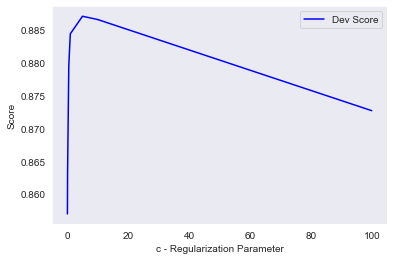

In [11]:
plot_scores(cs, sc_1, xlabel="c - Regularization Parameter")

In [12]:
# Choose Best c (class_weight)
np.random.seed(9)
Logit_L2 = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs',class_weight='balanced',
                              C=best_c,random_state=9)
Logit_L2.fit(X_train1, y_train)
y_hatd_Logit_L2 = Logit_L2.predict(X_dev1)
print(classification_report(y_dev, y_hatd_Logit_L2))
XFILE.append(("Logit_L2","X_train1",X_test1))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2755
           1       0.92      0.87      0.89      3245

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



### 4.1.2.3. Logistic Regression with Feature selection
<a id="LogisticRegression3"></a>
We ran a feature selection with Chi squared and SVD to decrease the possibility of overfitting and make the model simplier. 
#### 4.1.2.3.1. ChiSquared
<a id="chi2"></a>

In [13]:
# Choose the number of features (=k) according to Chi2
sc_2 = []
kss = [100, 300, 500, 1000, 1500, 2000, 2500]
best_k_chi2 = None
best_performance_dm = 0.0
np.random.seed(9)
for k in kss:
    print(k)
    selector = SelectKBest(chi2, k=k).fit(X_train1, y_train)
    X_train2 = selector.transform(X_train1)
    X_dev2 = selector.transform(X_dev1)
    Logit_chi2 = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                    class_weight='balanced',C=best_c,random_state=9)
    Logit_chi2.fit(X_train2, y_train)
    y_hatd_Logit_chi2 = Logit_chi2.predict(X_dev2)
    score = f1_score(y_dev, y_hatd_Logit_chi2, average='micro')
    sc_2.append(score)
    if score > best_performance_dm:
        best_performance_dm = score
        best_k_chi2 = k
        print("New best performance: {}".format(score))
    #print(classification_report(y_dev, y_hatd_Logit_chi2))
    #print()

100
New best performance: 0.8331666666666667
300
New best performance: 0.8656666666666667
500
New best performance: 0.8765
1000
New best performance: 0.888
1500
New best performance: 0.8916666666666667
2000
New best performance: 0.8963333333333333
2500


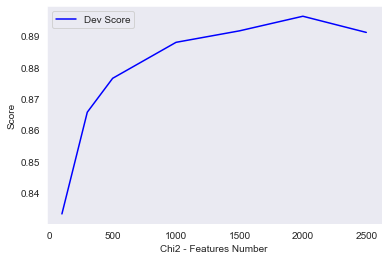

In [14]:
plot_scores(kss, sc_2, xlabel="Chi2 - Features Number")

In [15]:
# Choose Best k (class_weight and L2Reg)
np.random.seed(9)
selector = SelectKBest(chi2, k=best_k_chi2).fit(X_train1, y_train)
X_train2 = selector.transform(X_train1)
X_dev2 = selector.transform(X_dev1)
X_test2 = selector.transform(X_test1)

Logit_chi2 = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                    class_weight='balanced',C=best_c,random_state=9)
Logit_chi2.fit(X_train2, y_train)
y_hatd_Logit_chi2 = Logit_chi2.predict(X_dev2)
print(classification_report(y_dev, y_hatd_Logit_chi2))
XFILE.append(("Logit_chi2","X_train2",X_test2))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2755
           1       0.94      0.87      0.90      3245

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



#### 4.1.2.3.2. SVD Dimensionality Reduction
<a id="dim"></a>
We didn't see any significant improvement in the performance with SVD reduction.

In [16]:
# Choose the number of features (=k) according to SVD
sc_3 = []
ks = [100, 300, 500, 1000, 1500, 2000, 2500]
best_k_dim = None
best_performance_dm = 0.0
np.random.seed(9)

for k in ks:
    print(k)
    svd = TruncatedSVD(n_components=k)
    X_train_dim = svd.fit_transform(X_train1)
    X_dev_dim = svd.transform(X_dev1) 
    Logit_dim = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                    class_weight='balanced',C=best_c,random_state=9)
    Logit_dim.fit(X_train_dim, y_train)
    y_hatd_Logit_dim = Logit_dim.predict(X_dev_dim)
    score = f1_score(y_dev, y_hatd_Logit_dim, average='micro')
    sc_3.append(score)
    if score > best_performance_dm:
        best_performance_dm = score
        best_k_dim = k
        print("New best performance: {}".format(score))
    #print(classification_report(y_dev, y_hatd_Logit_dim))
    #print()

100
New best performance: 0.8565
300
New best performance: 0.8776666666666667
500
New best performance: 0.8835000000000001
1000
New best performance: 0.888
1500
New best performance: 0.8896666666666667
2000
2500


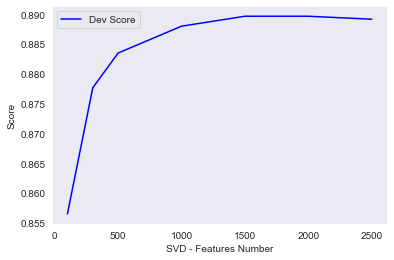

In [17]:
plot_scores(ks, sc_3, xlabel="SVD - Features Number")

In [18]:
# Choose Best k (class_weight and L2Reg)
np.random.seed(9)
svd = TruncatedSVD(n_components=best_k_dim)
X_train3 = svd.fit_transform(X_train1)
X_dev3 = svd.transform(X_dev1)
X_test3 = svd.transform(X_test1)

Logit_dim = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs',class_weight='balanced',random_state=9)
Logit_dim.fit(X_train3, y_train)
y_hatd_Logit_dim = Logit_dim.predict(X_dev3)
print(classification_report(y_dev, y_hatd_Logit_dim))
XFILE.append(("Logit_dim","X_train3",X_test3))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2755
           1       0.93      0.85      0.89      3245

    accuracy                           0.88      6000
   macro avg       0.88      0.89      0.88      6000
weighted avg       0.89      0.88      0.88      6000



### 4.1.2.4. Best LOGIT Model
<a id="best_SVM"></a>

**Which is the best LOGIT Model?**   

    1. Logit 
    2. Logit_cw (class_weight)
    3. Logit_L2 (c and class_weight)
    4. Logit_chi2 (k, c and class_weight)
    5. Logit_dim (k, c and class_weight)
    
Even if our data have been re-balanced, we still use the f1 metric.

In [19]:
# Compare all LOGIT Models with 1-2 grams
score_logit=[]
label_logit=[Logit,Logit_cw,Logit_L2,Logit_chi2,Logit_dim]
names_logit='Logit,Logit_cw,Logit_L2,Logit_chi2,Logit_dim'.split(",")
LOGITS=[y_hatd_Logit,y_hatd_Logit_cw,y_hatd_Logit_L2,y_hatd_Logit_chi2,y_hatd_Logit_dim]

for i in range(len(LOGITS)):
    score_logit.append((label_logit[i],names_logit[i],f1_score(y_dev,LOGITS[i],average='micro'),LOGITS[i]))

df_scores_logit=pd.DataFrame(score_logit,columns=["model","name","score","y_hatd"]).sort_values(by="score",ascending=False,ignore_index=True)
display(df_scores_logit)

print("Best LOGIT Model: {}, {}".format(df_scores_logit.name[0], df_scores_logit.score[0]))
Logit_BEST = df_scores_logit.model[0]
y_hatd_Logit_BEST = df_scores_logit.y_hatd[0]

PREDICTIONS = []
MODELS = []
NAMES = []
PREDICTIONS.append(y_hatd_Logit_BEST)
MODELS.append(Logit_BEST)
NAMES.append("Logit_BEST")
Xfile = [XFILE[i][1:3] for i in range(len(XFILE)) if XFILE[i][0]==df_scores_logit.name[0]]
XFILE.append(("Logit_BEST",Xfile[0][0], Xfile[0][1]))

,model,name,score,y_hatd
0,"LogisticRegression(C=5, class_weight='balanced...",Logit_chi2,0.896333,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
1,"LogisticRegression(C=5, class_weight='balanced...",Logit_L2,0.887000,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
2,"LogisticRegression(C=1.0, class_weight=None, d...",Logit,0.885667,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
3,"LogisticRegression(C=1.0, class_weight='balanc...",Logit_cw,0.884333,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
4,"LogisticRegression(C=1.0, class_weight='balanc...",Logit_dim,0.883667,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."


Best LOGIT Model: Logit_chi2, 0.8963333333333333


## 4.1.3. Logistic Regression with 2-6 grams features
<a id="logit26"></a>
This is another plain vanilla model, but since the results for this kind of text classification did not bring about any kind of improvement in the accuracy, but instead it decreased the level as a whole, it is not taken into account for the further tuning.

In [20]:
# Get the new sparse matrix 
np.random.seed(9)
vectorizer1 = TfidfVectorizer(ngram_range=(2,6), min_df=0.0001, max_df=0.7,analyzer='word')
X_train26 = vectorizer1.fit_transform(train[best_input_logistic])
X_dev26 = vectorizer1.transform(dev[best_input_logistic])
X_test26 = vectorizer1.transform(test[best_input_logistic])
print(X_train26.shape, X_dev26.shape, X_test26.shape)

(18000, 73601) (6000, 73601) (6000, 73601)


In [21]:
# Run the Classifier
np.random.seed(9)
Logit1 = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs',random_state=9)
%time Logit1.fit(X_train26, y_train)
y_hatd_Logit1 = Logit1.predict(X_dev26)
print(classification_report(y_dev,y_hatd_Logit1))

PREDICTIONS.append(y_hatd_Logit1)
MODELS.append(Logit1)
NAMES.append("Logit1")
XFILE.append(("Logit1",'X_train26',X_test26))

Wall time: 612 ms
              precision    recall  f1-score   support

           0       0.79      0.57      0.67      2755
           1       0.71      0.87      0.78      3245

    accuracy                           0.74      6000
   macro avg       0.75      0.72      0.72      6000
weighted avg       0.75      0.74      0.73      6000



In [22]:
# Run the Classifier with class_weight
np.random.seed(9)
Logit2 = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs',class_weight='balanced',random_state=9)
%time Logit2.fit(X_train26, y_train)
y_hatd_Logit2 = Logit2.predict(X_dev26)
print(classification_report(y_dev,y_hatd_Logit2))

PREDICTIONS.append(y_hatd_Logit2)
MODELS.append(Logit2)
NAMES.append("Logit2")
XFILE.append(("Logit2",'X_train26',X_test26))

Wall time: 349 ms
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      2755
           1       0.74      0.82      0.78      3245

    accuracy                           0.75      6000
   macro avg       0.75      0.74      0.74      6000
weighted avg       0.75      0.75      0.75      6000



## 4.1.4. Model Selection
<a id="further_model_selection"></a>
Are there some models that can perform better than the Logistic Regression?

In [23]:
labels = train.negative
models_clf = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=9),LinearSVC(random_state=9),
              MultinomialNB(),LogisticRegression(random_state=9),]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models_clf)))
entries = []
for model in models_clf:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [24]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.881833
LogisticRegression        0.882722
MultinomialNB             0.870556
RandomForestClassifier    0.634167
Name: accuracy, dtype: float64

## 4.1.5. Support Vector Machine
<a id="svm"></a>
Since SVM has apparently some chance to outperform Logit, we decided to dive deeper in it.  
Firstly, we check which ones among our inputs, it's the one which guarantees the highest accuracy in terms of preprocessing strength.

**Best Input:** `stems_ex`

In [25]:
np.random.seed(9)
SVC_linear = svm.SVC(kernel='linear', class_weight='balanced',random_state=9)

# Looking for the best input variable
models =["txt_contract","txt_expanded","tokens_ex","lemmas_ex","stems_ex","lemmas_fw_ex",
         "tokens_con","lemmas_con","stems_con","lemmas_fw_con"]
cv_fin=eval_input(SVC_linear,train,y_train,inputt=models,CV=3)

# Choose the best input variable
best_input_svc=cv_fin.index[0]
print(best_input_svc)

X_train5 = vectorizer.fit_transform(train[best_input_svc])
X_dev5 = vectorizer.transform(dev[best_input_svc])
X_test5 = vectorizer.transform(test[best_input_svc])

# Classifier
SVC_linear.fit(X_train5, y_train)
y_hatd_SVC_linear = SVC_linear.predict(X_dev5)
print(classification_report(y_dev,y_hatd_SVC_linear))
XFILE.append(("SVC_linear",'X_train5',X_test5))

stems_ex
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2755
           1       0.93      0.86      0.89      3245

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



### 4.1.5.1. Linear SVM with L2 Regularization
<a id="best_params_LSVM"></a>

From the analysis it seems that the model does not need heavy additional weights for the balancing of the labels. Indeed, the value of the c providing the highest accuracy is one.

In [26]:
best_c_svm = None
best_performance = 0.0
ccs = [1, 10, 100, 500, 1000, 5000]
sc_4 = []
np.random.seed(9)

for c in ccs:
    print(c)
    classifier_c = svm.SVC(kernel='linear', class_weight='balanced',C=c,random_state=9)
    classifier_c.fit(X_train5, y_train)
    predictions_c = classifier_c.predict(X_dev5)
    score = f1_score(y_dev, predictions_c, average='micro')
    sc_4.append(score)
    if score > best_performance:
        best_performance = score
        best_c_svm = c
        print("New best performance: {}".format(score)) 
    #print(classification_report(y_dev, predictions_c))
    #print()

1
New best performance: 0.8871666666666665
10
100
500
1000
5000


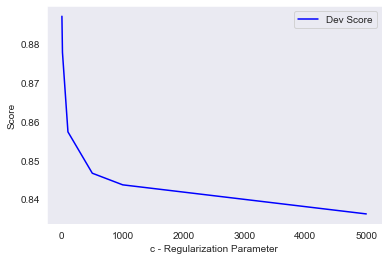

In [27]:
plot_scores(ccs, sc_4, xlabel="c - Regularization Parameter")

In [28]:
# Choose best c (class_weight)
SVC_linear_c_opt = svm.SVC(kernel='linear', class_weight='balanced',C=best_c_svm,random_state=9)
SVC_linear_c_opt.fit(X_train5, y_train)
y_hatd_SVC_linear_c_opt = SVC_linear_c_opt.predict(X_dev5)
print(classification_report(y_dev, y_hatd_SVC_linear_c_opt))
XFILE.append(("SVC_linear_c_opt",'X_train5',X_test5))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2755
           1       0.93      0.86      0.89      3245

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



### 4.1.5.2.  Linear SVM with Feature selection
<a id="feature_selection_LSVM"></a>
We ran a feature selection with Chi squared and SVD to decrease the possibility of overfitting and make the model simplier. 
#### 4.1.5.2.1. ChiSquared
<a id="chi2_LSVM"></a>

In [29]:
sc_5 = []
ksSVM = [100, 300, 500, 1000, 1500, 2000, 2500]
best_k_chi2_SVM = None
best_performance_dm = 0.0
np.random.seed(9)
for k in ksSVM:
    print(k)
    selector = SelectKBest(chi2, k=k).fit(X_train5, y_train)
    X_train_sel = selector.transform(X_train5)
    X_dev_sel = selector.transform(X_dev5)
    LSVM_chi2 = svm.SVC(kernel='linear', C = best_c_svm, class_weight='balanced')
    LSVM_chi2.fit(X_train_sel, y_train)
    y_hatd_LSVM_chi2 = LSVM_chi2.predict(X_dev_sel)
    print(classification_report(y_dev, y_hatd_LSVM_chi2))
    score = f1_score(y_dev, y_hatd_LSVM_chi2, average='micro')
    sc_5.append(score)
    if score > best_performance_dm:
        best_performance_dm = score
        best_k_chi2_SVM = k
        print("New best performance: {}".format(score))
    #print(classification_report(y_dev, y_hatd_Logit_chi2))
    #print()

100
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      2755
           1       0.96      0.71      0.82      3245

    accuracy                           0.83      6000
   macro avg       0.85      0.84      0.83      6000
weighted avg       0.86      0.83      0.82      6000

New best performance: 0.8263333333333333
300
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      2755
           1       0.95      0.78      0.86      3245

    accuracy                           0.86      6000
   macro avg       0.87      0.87      0.86      6000
weighted avg       0.88      0.86      0.86      6000

New best performance: 0.8601666666666666
500
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      2755
           1       0.95      0.81      0.87      3245

    accuracy                           0.87      6000
   macro avg       0.88      0.88 

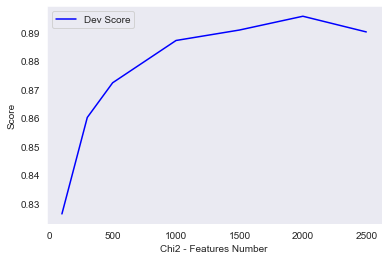

In [30]:
plot_scores(ksSVM, sc_5, xlabel="Chi2 - Features Number")

In [31]:
# Choose best k (class_weight and L2Reg)
selector = SelectKBest(chi2, k=best_k_chi2_SVM).fit(X_train5, y_train)
X_train_sel = selector.transform(X_train5)
X_dev_sel = selector.transform(X_dev5)
X_test_sel = selector.transform(X_test5)
LSVM_chi2 = svm.SVC(kernel='linear', C = best_c_svm, class_weight='balanced',random_state=9)
LSVM_chi2.fit(X_train_sel, y_train)
y_hatd_LSVM_chi2 = LSVM_chi2.predict(X_dev_sel)
print(classification_report(y_dev, y_hatd_LSVM_chi2))
XFILE.append(("LSVM_chi2",'X_train_sel',X_test_sel))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2755
           1       0.94      0.86      0.90      3245

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



#### 4.1.5.2.2. Dimensionality Reduction
<a id="SVD_LSVM"></a>


In [32]:
sc_6 = []
kssSVM = [100, 300, 500, 1000, 1500, 2000, 2500]
best_k_dim_SVM = None
best_performance_dm = 0.0
np.random.seed(9)
for k in kssSVM:
    print(k)
    svd = TruncatedSVD(n_components=k)
    X_train_dim = svd.fit_transform(X_train5)
    X_dev_dim = svd.transform(X_dev5)
    LSVM_dim = svm.SVC(kernel='linear', C = best_c_svm, class_weight='balanced',random_state=9)
    LSVM_dim.fit(X_train_dim, y_train)
    y_hatd_LSVM_dim = LSVM_dim.predict(X_dev_dim)
    score = f1_score(y_dev, y_hatd_LSVM_dim, average='micro')
    sc_6.append(score)
    if score > best_performance_dm:
        best_performance_dm = score
        best_k_dim_SVM = k
        print("New best performance: {}".format(score))
    #print(classification_report(y_dev, y_hatd_LSVM_dim))
    #print()

100
New best performance: 0.8446666666666667
300
New best performance: 0.8695
500
New best performance: 0.882
1000
New best performance: 0.8863333333333333
1500
New best performance: 0.8886666666666667
2000
New best performance: 0.8893333333333333
2500
New best performance: 0.8895


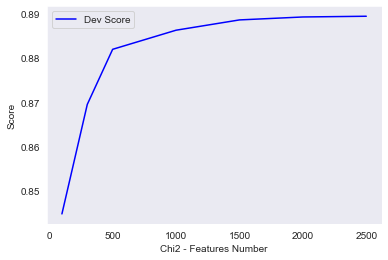

In [33]:
plot_scores(kssSVM, sc_6, xlabel="Chi2 - Features Number")

In [34]:
# Choose best k (class_weight and L2Reg)
np.random.seed(9)
svd = TruncatedSVD(n_components=best_k_dim_SVM)
X_train_dim = svd.fit_transform(X_train5)
X_dev_dim = svd.transform(X_dev5)
X_test_dim = svd.transform(X_test5)

LSVM_dim = svm.SVC(kernel='linear', C = best_c_svm, class_weight='balanced',random_state=9)
LSVM_dim.fit(X_train_dim, y_train)
y_hatd_LSVM_dim = LSVM_dim.predict(X_dev_dim)
print(classification_report(y_dev, y_hatd_LSVM_dim))
XFILE.append(("LSVM_dim",'X_train_dim',X_test_dim))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2755
           1       0.93      0.86      0.89      3245

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



### 4.1.5.3. RBF SVM with Penalty and Gamma
<a id="best_params_RSVM"></a>
We then moved to a SVM with radial basis function kernel, to increase our accuracy
C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly.  
Gamma defines how far the influence of a single training example reaches (low = far).

In [35]:
np.random.seed(9)
best_C = None
best_gamma = None
best_performance = 0.0
Cs = [1, 10, 100, 500, 1000, 5000]
gammas = [0.1, 1, 10, 100, 1000]
sc_7 = []

for c in Cs:
    for g in gammas:
        print(c, g)
        classifier_c = svm.SVC(kernel='rbf', gamma=g, C = c, class_weight='balanced',random_state=9)
        classifier_c.fit(X_train5, y_train)
        predictions_c = classifier_c.predict(X_dev5)
        score = f1_score(y_dev, predictions_c, average='micro')
        sc_7.append(score)
        if score > best_performance:
            best_performance = score
            best_C = c
            best_gamma=g
            print("New best performance: {}".format(score))   
    #print(classification_report(y_dev, predictions_c))
    #print()

1 0.1
New best performance: 0.8796666666666667
1 1
New best performance: 0.8846666666666667
1 10
1 100
1 1000
10 0.1
New best performance: 0.8875
10 1
10 10
10 100
10 1000
100 0.1
100 1
New best performance: 0.8876666666666667
100 10
100 100
100 1000
500 0.1
500 1
New best performance: 0.8888333333333334
500 10
500 100
500 1000
1000 0.1
1000 1
1000 10
1000 100
1000 1000
5000 0.1
5000 1
5000 10
5000 100
5000 1000


In [36]:
# Choose best c and gamma (class_weight)
RSVM=svm.SVC(kernel='rbf', gamma=best_gamma, C = best_C, class_weight='balanced',random_state=9)
RSVM.fit(X_train5, y_train)
y_hatd_RSVM = RSVM.predict(X_dev5)
print(classification_report(y_dev, y_hatd_RSVM))
XFILE.append(("RSVM",'X_train5',X_test5))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      2755
           1       0.92      0.87      0.89      3245

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



### 4.1.5.4. RBF SVM with Feature selection
<a id="feature_selection_RSVM"></a>

#### 4.1.5.4.1. ChiSquared
<a id="chi2_RSVM"></a>


In [37]:
np.random.seed(9)
sc_8 = []
ksRBF = [100, 300, 500, 1000, 1500, 2000, 2500]
best_k_chi2_RBF = None
best_performance_dm = 0.0

for k in ksRBF:
    print(k)
    selector = SelectKBest(chi2, k=k).fit(X_train5, y_train)
    X_train_sel = selector.transform(X_train5)
    X_dev_sel = selector.transform(X_dev5)
    SVM_chi2 = svm.SVC(kernel='rbf', gamma=best_gamma, C = best_C,class_weight='balanced',random_state=9)
    SVM_chi2.fit(X_train_sel, y_train)
    y_hatd_SVM_chi2 = SVM_chi2.predict(X_dev_sel)
    score = f1_score(y_dev, y_hatd_SVM_chi2, average='micro')
    sc_8.append(score)
    if score > best_performance_dm:
        best_performance_dm = score
        best_k_chi2_RBF = k
        print("New best performance: {}".format(score))
    #print(classification_report(y_dev, y_hatd_SVM_chi2))
    #print()

100
New best performance: 0.8328333333333333
300
New best performance: 0.8498333333333333
500
New best performance: 0.8523333333333334
1000
New best performance: 0.8588333333333333
1500
New best performance: 0.8658333333333333
2000
2500
New best performance: 0.8756666666666668


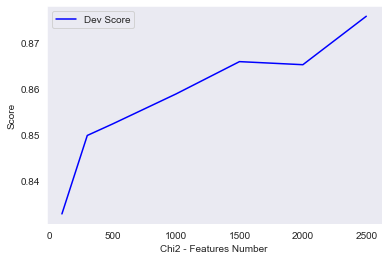

In [38]:
plot_scores(ksRBF, sc_8, xlabel="Chi2 - Features Number")

In [39]:
# Choose best k (class_weight, gamma, penalty)
np.random.seed(9)
selector = SelectKBest(chi2, k=best_k_chi2_RBF).fit(X_train5, y_train)
X_train_sell = selector.transform(X_train5)
X_dev_sell = selector.transform(X_dev5)
X_test_sell = selector.transform(X_test5)

RSVM_chi2 = svm.SVC(kernel='rbf', gamma=best_gamma , C = best_C, class_weight='balanced',random_state=9)
RSVM_chi2.fit(X_train_sell, y_train)
y_hatd_RSVM_chi2 = RSVM_chi2.predict(X_dev_sell)
print(classification_report(y_dev, y_hatd_RSVM_chi2))
XFILE.append(("RSVM_chi2",'X_train_sell',X_test_sell))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2755
           1       0.90      0.87      0.88      3245

    accuracy                           0.88      6000
   macro avg       0.87      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



#### 4.1.5.4.2. SVD Dimensionality Reduction
<a id="SVD_RSVM"></a>

In [40]:
np.random.seed(9)
sc_9 = []
kssRBF = [100, 300, 500, 1000, 1500, 2000, 2500]
best_k_dim_RBF = None
best_performance_dm = 0.0

for k in kssRBF:
    print(k)
    svd = TruncatedSVD(n_components=k) 
    X_train_dim = svd.fit_transform(X_train5)
    X_dev_dim = svd.transform(X_dev5)
    RSVM_dim = svm.SVC(kernel='rbf', gamma=best_gamma, C = best_C,class_weight='balanced',random_state=9)
    RSVM_dim.fit(X_train_dim, y_train)
    y_hatd_RSVM_dim = RSVM_dim.predict(X_dev_dim)
    score = f1_score(y_dev, y_hatd_RSVM_dim, average='micro')
    sc_9.append(score)
    if score > best_performance_dm:
        best_performance_dm = score
        best_k_dim_RBF = k
        print("New best performance: {}".format(score))
    #print(classification_report(y_dev, y_hatd_RSVM_dim))
    #print()

100
New best performance: 0.8448333333333333
300
New best performance: 0.865
500
New best performance: 0.8675
1000
New best performance: 0.8815
1500
New best performance: 0.89
2000
2500


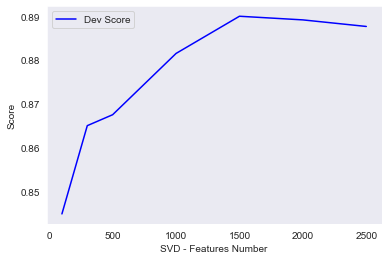

In [41]:
plot_scores(kssRBF, sc_9, xlabel="SVD - Features Number")

In [42]:
# Choose best k (class_weight, gamma, penalty)
np.random.seed(9)
svd = TruncatedSVD(n_components=best_k_dim_RBF)
X_train_dimm = svd.fit_transform(X_train5)
X_dev_dimm = svd.transform(X_dev5)
X_test_dimm = svd.transform(X_test5)

RSVM_dim = svm.SVC(kernel='rbf', gamma=best_gamma, C = best_C,random_state=9)
RSVM_dim.fit(X_train_dimm, y_train)
y_hatd_RSVM_dim = RSVM_dim.predict(X_dev_dimm)
print(classification_report(y_dev, y_hatd_RSVM_dim))
XFILE.append(("RSVM_dim",'X_train_dimm',X_test_dimm))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2755
           1       0.89      0.89      0.89      3245

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



### 4.1.5.5. Best SVM Model
<a id="best_SVM"></a>

**Which is the best SVM Model?**   

    1. SVC_linear (class_weight)
    2. SVC_linear_c_opt (c and class_weight)
    3. LSVM_chi2 (k, c and class_weight)
    4. LSVM_dim (k, c and class_weight)
    5. RSVM (gamma, c and class_weight)
    6. RSVM_chi2 (k, gamma, c and class_weight)
    7. RSVM_dim (k, gamma, c and class_weight)  
    
Even if our data have been re-balanced, we still use the f1 metric.

In [43]:
# Compare all SVM Models 
score_SVM=[]
label_SVM=[RSVM_chi2,RSVM_dim,RSVM,LSVM_dim,LSVM_chi2,SVC_linear_c_opt,SVC_linear]
name_SVM = "RSVM_chi2,RSVM_dim,RSVM,LSVM_dim,LSVM_chi2,SVC_linear_c_opt,SVC_linear".split(",")
SVMS=[y_hatd_RSVM_chi2,y_hatd_RSVM_dim,y_hatd_RSVM,y_hatd_LSVM_dim,y_hatd_LSVM_chi2,
      y_hatd_SVC_linear_c_opt,y_hatd_SVC_linear]

for i in range(len(SVMS)):
    score_SVM.append((label_SVM[i],name_SVM[i],f1_score(y_dev,SVMS[i],average='micro'),SVMS[i]))

df_scores_SVM=pd.DataFrame(score_SVM,columns=["model","name","score","y_hatd"]).sort_values(by="score",
                                                                                            ascending=False,
                                                                                            ignore_index=True)
display(df_scores_SVM)

print("Best SVM Model: {}, {}".format(df_scores_SVM.name[0], df_scores_SVM.score[0]))
SVM_BEST = df_scores_SVM.model[0]
y_hatd_SVM_BEST = df_scores_SVM.y_hatd[0]

PREDICTIONS.append(y_hatd_SVM_BEST)
MODELS.append(SVM_BEST)
NAMES.append("SVM_BEST")
Xfile = [XFILE[i][1:3] for i in range(len(XFILE)) if XFILE[i][0]==df_scores_SVM.name[0]]
XFILE.append(("SVM_BEST",Xfile[0][0], Xfile[0][1]))

,model,name,score,y_hatd
0,"SVC(C=1, break_ties=False, cache_size=200, cla...",LSVM_chi2,0.895667,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
1,"SVC(C=500, break_ties=False, cache_size=200, c...",RSVM,0.888833,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
2,"SVC(C=1, break_ties=False, cache_size=200, cla...",LSVM_dim,0.888667,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
3,"SVC(C=1, break_ties=False, cache_size=200, cla...",SVC_linear_c_opt,0.887167,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
4,"SVC(C=1.0, break_ties=False, cache_size=200, c...",SVC_linear,0.887167,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
5,"SVC(C=500, break_ties=False, cache_size=200, c...",RSVM_dim,0.882500,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."
6,"SVC(C=500, break_ties=False, cache_size=200, c...",RSVM_chi2,0.875667,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ..."


Best SVM Model: LSVM_chi2, 0.8956666666666667


## 4.1.6. Multilayer Perceptron
<a id="mlp"></a>
Now, we moved to more complex models: Neural Networks.     
From a basic one, that takes as input a sparse matrix, we moved to a more complex and creative one.    
As before, we carried out an analysis with CV on the training set to see what was the input variable that leads to better performance.

**Best Input:** `lemmas_fw_con`

In [44]:
# BASIC MLP
np.random.seed(9) #lemmas_fw_con
MLP = MLPClassifier(solver="lbfgs", activation="relu",alpha=1e-5, 
                    hidden_layer_sizes=(256),max_iter=500,random_state=9)

# Looking for the best input variable
cv_fin=eval_input(MLP,train,y_train,inputt=models,CV=3)

# Choose the best input variable
best_input_nn=cv_fin.index[0]
print(best_input_nn)

X_train6 = vectorizer.fit_transform(train[best_input_nn])
X_dev6 = vectorizer.transform(dev[best_input_nn])
X_test6 = vectorizer.transform(test[best_input_nn])

train_dev=data[:train_size+dev_size]
X_train_dev6 =vectorizer.transform(train_dev[best_input_nn])

MLP.fit(X_train6, y_train)
y_hatd_MLP = MLP.predict(X_dev6)
print(classification_report(y_dev, y_hatd_MLP))

C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

lemmas_fw_con
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2755
           1       0.86      0.85      0.86      3245

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



### 4.1.6.1. Best parameters
<a id="best_params_mlp"></a>
Tuning of the following parameters: 
- Layer/s size, 
- Activation function, 
- Alpha.

In [45]:
np.random.seed(9)
best_performance = 0.0
best_layer = None
best_activation = None
best_alpha=None
layerss = [(128,),(256,),(64,64),(64,)]
activations=["logistic","relu"]
alphas=[0.1,0.001,0.00001]
sc_10 = []

for alfa in alphas:
    for activation in activations:
        for layer in layerss:
            clf = MLPClassifier(solver="lbfgs", activation=activation,alpha=alfa, hidden_layer_sizes=layer,
                                max_iter=500,random_state=9)
            clf.fit(X_train6, y_train)
            predictions = clf.predict(X_dev6)
            score = f1_score(y_dev, predictions, average='micro')
            sc_10.append((activation,layer,alfa,score))
            if score > best_performance:
                best_performance = score
                best_layer = layer
                best_activation= activation
                best_alpha= alfa
                print("New best performance: {}".format(score))
            #print(classification_report(y_dev, predictions))
            #print()

print("Use",best_activation,"with",best_layer,"layers, and alpha:",str(best_alpha),"with performance:",str(best_performance))

New best performance: 0.8861666666666667


C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

New best performance: 0.8865
Use relu with (64, 64) layers, and alpha: 1e-05 with performance: 0.8865


C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [46]:
df=pd.DataFrame(sc_10,columns=["activation","layer","alpha","score"]).sort_values(by="score",ascending=False)
df

,activation,layer,alpha,score
22,relu,"(64, 64)",0.00001,0.886500
0,logistic,"(128,)",0.10000,0.886167
6,relu,"(64, 64)",0.10000,0.885000
7,relu,"(64,)",0.10000,0.883333
4,relu,"(128,)",0.10000,0.883167
9,logistic,"(256,)",0.00100,0.882500
12,relu,"(128,)",0.00100,0.882167
14,relu,"(64, 64)",0.00100,0.871000
18,logistic,"(64, 64)",0.00001,0.865167
5,relu,"(256,)",0.10000,0.862500


In [47]:
# Choose best Activation, Layer, Alpha
np.random.seed(9)
MLP2 = MLPClassifier(solver="lbfgs", activation=best_activation,alpha=best_alpha, 
                     hidden_layer_sizes=best_layer,max_iter=500,random_state=9)
MLP2.fit(X_train6, y_train)
y_hatd_MLP2=MLP2.predict(X_dev6)
print(classification_report(y_dev, y_hatd_MLP2))

PREDICTIONS.append(y_hatd_MLP2)
MODELS.append(MLP2)
NAMES.append("MLP2")
XFILE.append(("MLP2","X_train6",X_test6))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2755
           1       0.90      0.88      0.89      3245

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



## 4.1.7. MLP with multiple labels as input
<a id="mlp2"></a>
Here we tried to make an experiment, an iterative neural network where, after each step, the input matrix is updated with the predictions of that step. The final output is the negative/positive dummy variable. The predictions that update the input matrix are the specific labels: toxic, obscene, insult, severe_toxic, identity_hate, threat.  
Since these predictions are strongly correlated with the output variable (`negative`), we believed that they should cause an increase in the overall performance. However, we prove ourselves wrong. 

In [48]:
np.random.seed(9)
tr=[]
de=[]
te=[]
td=[]
z=["toxic","obscene","insult","severe_toxic","identity_hate","threat"]
MLP3 = MLPClassifier(solver="lbfgs", activation=best_activation,alpha=1e-5, 
                     hidden_layer_sizes=best_layer,max_iter=1000,random_state=9)

def predict(clf,trainx,trainy,testx):
    clf.fit(trainx,trainy)
    testy=clf.predict(testx)
    return testy

for i in z:
    tr.append(train[i])
    de.append(dev[i])
    te.append(test[i])
    td.append(train_dev[i])
    
for i in range(len(z)):
    z_hat=predict(MLP3,X_train6,tr[i],X_train_dev6)
    z_hat1=z_hat[:train_size]
    z_hat2=z_hat[train_size:]
    z_hat1=np.asmatrix(z_hat1).T
    z_hat2=np.asmatrix(z_hat2).T
    if i==0:
        hat1=z_hat1
        hat2=z_hat2
    else:
        hat1=np.concatenate((hat1,z_hat1),axis=1)
        hat2=np.concatenate((hat2,z_hat2),axis=1)

X_train7=sparse.hstack([X_train6,hat1])
X_dev7=sparse.hstack([X_dev6,hat2])
MLP3.fit(X_train7, y_train)
y_hatd_MLP3=MLP3.predict(X_dev7)
print(classification_report(y_dev, y_hatd_MLP3))

PREDICTIONS.append(y_hatd_MLP3)
MODELS.append(MLP3)
NAMES.append("MLP3")
XFILE.append(("MLP3","X_train7","NO"))

C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ospite\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


              precision    recall  f1-score   support

           0       0.85      0.80      0.83      2755
           1       0.84      0.88      0.86      3245

    accuracy                           0.85      6000
   macro avg       0.85      0.84      0.85      6000
weighted avg       0.85      0.85      0.85      6000



## 4.1.8. Convolutional NN 
<a id="cnn"></a>
Finally we ran a CNN with a double dropout, to avoid overfitting, and the sigmoid activation function for the last layer, because it seems to lead the best performance. The tuning of the CNN parameters isn't marked as code because it's super slow. 

In [49]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen,hidden_layer):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(hidden_layer, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt.show()

In [50]:
X_trainn=train[best_input_nn].values
X_devv=dev[best_input_nn].values
X_testt=test[best_input_nn].values

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_trainn)
X_train8 = tokenizer.texts_to_sequences(X_trainn)
X_dev8 = tokenizer.texts_to_sequences(X_devv)
X_test8 = tokenizer.texts_to_sequences(X_testt)

vocab_size = len(tokenizer.word_index) + 1
X_train9 = sequence.pad_sequences(X_train8, maxlen=100)
X_dev9 = sequence.pad_sequences(X_dev8, maxlen=100)
X_test9 = sequence.pad_sequences(X_test8, maxlen=100)

C:\Users\Ospite\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18000 samples, validate on 6000 samples
Epoch 1/6
18000/18000 [==============================] - 33s 2ms/step - loss: 0.3647 - accuracy: 0.8281 - val_loss: 0.2440 - val_accuracy: 0.8963
Epoch 2/6
18000/18000 [==============================] - 33s 2ms/step - loss: 0.1805 - accuracy: 0.9342 - val_loss: 0.2471 - val_accuracy: 0.9022
Epoch 3/6
18000/18000 [==============================] - 33s 2ms/step - loss: 0.1128 - accuracy: 0.9623 - val_loss: 0.2923 - val_accuracy: 0.8985
Epoch 4/6
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0698 - accuracy: 0.9781 - val_loss: 0.3694 - val_accuracy: 0.8898
Epoch 5/6
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0466 - accuracy: 0.9852 - val_loss: 0.3887 - val_accuracy: 0.8903
Epoch 6/6
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0318 - accuracy: 0.9904 - val_loss: 0.4856 - val_accuracy: 0.8875


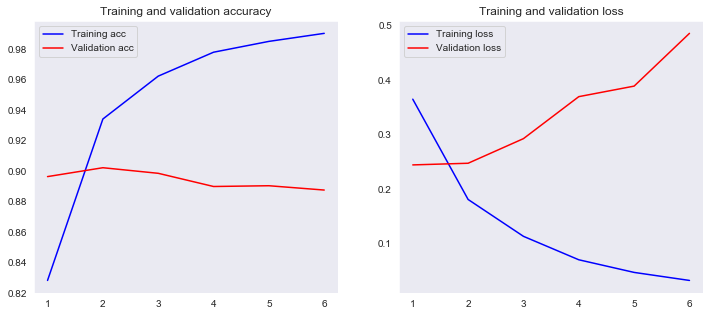

In [51]:
# Only 6 Iterations: we found out, after many runs, that after 6 epochs the performance decreases due to overfitting 
np.random.seed(9)
num_filters, kernel_size, vocab_size, embedding_dim, maxlen,hidden_layer=64,3,20000,100,100,10
CNN=create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen,hidden_layer)
hist6=CNN.fit(X_train9, y_train, batch_size=32, epochs=6,validation_data=(X_dev9, y_dev))
plot_history(hist6)

In [52]:
y_hatd_CNN=CNN.predict(X_dev9, verbose=1)
y_hatd_CNN[y_hatd_CNN>0.5]=1
y_hatd_CNN[y_hatd_CNN<=0.5]=0
y_hatd_CNN.astype(int)
print(classification_report(y_dev, y_hatd_CNN))

PREDICTIONS.append(y_hatd_CNN)
MODELS.append(CNN)
NAMES.append("CNN")
XFILE.append(("CNN","X_train9",X_test9))

6000/6000 [==============================] - 0s 42us/step
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2755
           1       0.88      0.92      0.90      3245

    accuracy                           0.89      6000
   macro avg       0.89      0.88      0.89      6000
weighted avg       0.89      0.89      0.89      6000



## 4.1.9. Best Classifier
<a id="recap"></a>


In [53]:
print(NAMES)
assert len(PREDICTIONS)==len(NAMES)==len(MODELS)
xfiles = [XFILE[j][1] for j in range(len(XFILE)) for i in range(len(NAMES)) if XFILE[j][0] == NAMES[i] ]

f1 = pd.DataFrame()
f1["Classifier"] = NAMES
f1["f1_micro"] = [f1_score(y_dev, i, average='micro') for i in PREDICTIONS]
f1["f1_macro"] = [f1_score(y_dev, i, average='macro') for i in PREDICTIONS]
f1["precision_micro"] = [precision_score(y_dev, i, average='micro') for i in PREDICTIONS]
f1["precision_macro"] = [precision_score(y_dev, i, average='macro') for i in PREDICTIONS]
f1["recall_micro"] = [recall_score(y_dev, i, average='micro') for i in PREDICTIONS]
f1["recall_macro"] = [recall_score(y_dev, i, average='macro') for i in PREDICTIONS]
f1["y_hatd"] = PREDICTIONS
f1["models"] = MODELS
f1['X_test'] = xfiles
f1 = f1[~f1['Classifier'].apply(tuple).duplicated()]
f1 = f1.sort_values(by="f1_micro",ascending=False,ignore_index=True)

for i in range(len(f1)):
    if f1.Classifier[i] not in ['Logit1', 'Logit2']:
        Classifier_BEST = f1.models[i] 
        y_hatd_Classifier_BEST = f1.y_hatd[i]
        name_Classifier_BEST = f1.Classifier[i]
        xfile_Classifier_BEST = f1.X_test[i]
        break
    else: 
        i+=1


display(f1)
X_TEST_Classifier_BEST = [XFILE[j][2] for j in range(len(XFILE)) if XFILE[j][0] == name_Classifier_BEST][0]

['Logit_BEST', 'Logit1', 'Logit2', 'SVM_BEST', 'MLP2', 'MLP3', 'CNN']


,Classifier,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro,y_hatd,models,X_test
0,Logit_BEST,0.896333,0.896156,0.896333,0.896293,0.896333,0.898953,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ...","LogisticRegression(C=5, class_weight='balanced...",X_train2
1,SVM_BEST,0.895667,0.895531,0.895667,0.896098,0.895667,0.898721,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ...","SVC(C=1, break_ties=False, cache_size=200, cla...",X_train_sel
2,CNN,0.887500,0.886242,0.887500,0.888681,0.887500,0.884813,"[[1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1....",<keras.engine.sequential.Sequential object at ...,X_train9
3,MLP2,0.886500,0.885960,0.886500,0.885422,0.886500,0.886793,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ...","MLPClassifier(activation='relu', alpha=1e-05, ...",X_train6
4,MLP3,0.846833,0.845020,0.846833,0.847639,0.846833,0.843626,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ...","MLPClassifier(activation='relu', alpha=1e-05, ...",X_train7
5,Logit2,0.747333,0.742257,0.747333,0.749071,0.747333,0.740814,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...","LogisticRegression(C=1.0, class_weight='balanc...",X_train26
6,Logit1,0.735667,0.723673,0.735667,0.750049,0.735667,0.723478,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...","LogisticRegression(C=1.0, class_weight=None, d...",X_train26


SVM_BEST
X_train_sel


## 4.1.10. Bootstrap sampling significance tests
<a id="boot"></a>
Performance between your **best model** and each of the two baselines (y_hatd_dummy, y_hatd_Logit_BEST):

In [54]:
# BEST MODEL vs. DUMMY CLASSIFIER
p_value1, deltas1 = bootstrap_sample(y_hatd_Classifier_BEST, y_hatd_dummy, y_dev, samples=1000,
                                     score=f1_score, average='micro')
print(p_value1, p_value1 < 0.01)
print(f1_score(y_dev, y_hatd_Classifier_BEST, average='micro'), f1_score(y_dev, y_hatd_dummy, average='micro'))

0.0 True
0.8956666666666667 0.5408333333333334


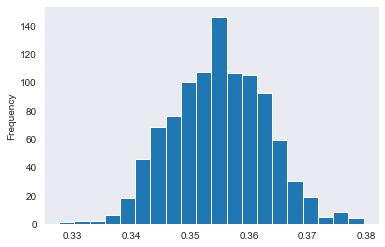

In [55]:
%matplotlib inline
pd.Series(deltas1).plot.hist(bins=20)
plt.show()

In [56]:
# BEST MODEL vs. LOGISTIC REGRESSION
try:
    p_value2, deltas2 = bootstrap_sample(y_hatd_Classifier_BEST, y_hatd_Logit, y_dev, samples=1000, score=f1_score, average='micro')
    print(p_value2, p_value2 < 0.01)
    print(f1_score(y_dev, y_hatd_Classifier_BEST, average='micro'), f1_score(y_dev, y_hatd_Logit, average='micro'))
except:
    print("best model is still logistic")
    p_value2, deltas2 = bootstrap_sample( y_hatd_Logit,y_hatd_Classifier_BEST, y_dev, samples=1000, score=f1_score, average='micro')
    print(p_value2, p_value2 < 0.01)
    print(f1_score(y_dev, y_hatd_Logit, average='micro'),f1_score(y_dev, y_hatd_Classifier_BEST, average='micro'))

0.0 True
0.8956666666666667 0.8856666666666667


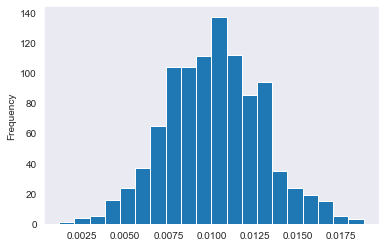

In [57]:
pd.Series(deltas2).plot.hist(bins=20)
plt.show()

In [60]:
# FINALLY: TEST set 
print("The Classifier_BEST needs the X_test paired with: {}".format(xfile_Classifier_BEST))
y_hatt_dummy = dummy.predict(X_test)
y_hatt_Logit = Logit.predict(X_test1)

y_hatt_Classifier_BEST = Classifier_BEST.predict(X_TEST_Classifier_BEST)

#print("BEST: {} | Test Score: {}".format(name_Classifier_BEST, f1_score(y_test, y_hatt_Classifier_BEST, average='micro')))
#print("Logit | Test Score: {}".format(f1_score(y_test, y_hatt_Logit, average='micro')))
#print("Dummy | Test Score: {}".format(f1_score(y_test, y_hatt_dummy, average='micro')))

The Classifier_BEST needs the X_test paired with: X_train_sel
0.8915 0.887
